# **Introduction**


In this notebook, we extend the Perceptron Learning Algorithm (PLA) to classify handwritten digits from the MNIST dataset. The approach involves implementing 10 separate perceptrons, each responsible for distinguishing a specific digit from all other digits using a one-vs-all classification strategy. This extension demonstrates the application of PLA to a multi-class classification problem and provides insights into the performance and behavior of simple linear classifiers on real-world data.

In [ ]:
# Imports
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
# Pandas is a non-trivial requirement


In [ ]:
# Fetch MNIST dataset, and unpack it to images (X) and labels (Y)
def set_data():

    # Import data
    mnist = fetch_openml('mnist_784', version=1)

    # Extract Images and labels
    X = mnist['data'].values
    Y = mnist['target'].to_numpy(dtype=int)

    # Add ones vector to implement the 'bias trick'
    X = np.column_stack([np.ones(X.shape[0]), X])

    return X, Y




In [ ]:
# Definition of the Binary perceptron, which given an input digit and the MNIST
# will classify the image.

class BinaryPerceptron:

    def __init__(self, images_train, labels_train, images_test, labels_test, digit, num_features=785):
        self.digit = digit  # Digit to classify
        self.w = np.zeros(num_features)
        self.X_train = images_train
        self.Y_train = labels_train
        self.X_test = images_test
        self.Y_test = labels_test
        self.train_losses = []
        self.test_losses = []

    def calc_accuracy_train(self):
        # Calculate accuracy on train data
        return self.calc_accuracy(self.X_train, self.Y_train)

    def calc_accuracy_test(self):
        # Calculate accuracy on test data
        return self.calc_accuracy(self.X_test, self.Y_test)

    def calc_accuracy(self, X, Y):
        # Calculate accuracy on given data

        Y_hat = self.predict(X)
        Y_signed = np.where(Y != self.digit, -1, 1) # Sign function
        correct = sum(Y_hat == Y_signed) # Count number of classfied labels
        total = Y_hat.size
        return 100 * correct / total

    def calc_confusion_matrix(self):
        # Calculate confusion matrix of the trained binary perceptron

        Y_test_predictions = self.predict(self.X_test)  # Predictions on test data
        Y_test_signed = np.where(Y_test == self.digit, 1, -1)  # Binarize the labels of test set
        conf_matrix = confusion_matrix(Y_test_signed, Y_test_predictions)
        return conf_matrix

    def print_statistics(self):
        # Print confusion matrix and metrices based on it

        conf_matrix = self.calc_confusion_matrix()

        TN, FP, FN, TP = conf_matrix.ravel()  # Unpack values of confusion matrix

        # Print values of Confusion matrix
        print("True Negative (TN):", TN)
        print("False Positive (FP):", FP)
        print("False Negative (FN):", FN)
        print("True Positive (TP):", TP)

        # Calculate statistics based on the confusion matrix
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)

        # Print metrices based on the confusion matrix
        print("True Positive Rate (TPR):", TPR)
        print("True Negative Rate (TNR):", TNR)
        print("Test data Accuracy (ACC):", ACC)
        print("")

    def plot_losses(self):
        # Plot loss(epoch_number)

        train_losses = self.train_losses
        test_losses = self.test_losses

        plt.clf()
        plt.title("Loss for perceptron of digit '" + str(self.digit) + "'")
        plt.xlabel("Epoch number")
        plt.ylabel("Loss")
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="train loss")
        plt.plot(range(1, len(test_losses) + 1), test_losses, label="test loss")
        plt.legend(['Train loss', 'Test loss'])
        # plt.savefig("perceptron " + str(self.digit) + "  loss")

        plt.show()

    def predict(self, X, w=None):
        # Predict X with w


        if w is None:
            w = self.w # Default weight vector

        predicted_scores = np.dot(X, np.transpose(w)) # Prediction
        Y_hat = np.where(predicted_scores >= 0, 1, -1) # Binarize labels
        return Y_hat

    def train(self, epochs):

        correct_train_labels_signed = np.where(self.Y_train != self.digit, -1, 1)  # Binarize train labels
        correct_test_labels_signed = np.where(self.Y_test != self.digit, -1, 1)  # Binarize on test labels
        # Y_train_signs = np.where(self.Y_train == self.digit, 1, -1)

        w_pocket = None
        w_pocket_train_errors = 0

        for epoch in range(epochs):

            # Predict labels with current weights vector
            predicted_scores_signs_train = self.predict(self.X_train)
            next_w = self.w

            # find misclassifien indices
            misclassified_indices = np.where(correct_train_labels_signed != predicted_scores_signs_train)[0]

            # Iterate misclassified indices to correct w
            for misclassified_label_index in misclassified_indices:
                next_w += correct_train_labels_signed[misclassified_label_index] * self.X_train[misclassified_label_index, :]

            # Evaluate new weights vector
            predicted_scores_signs_train = self.predict(self.X_train, next_w)
            train_errors = sum(predicted_scores_signs_train != correct_train_labels_signed)


            # Update pocket weights vector if needed
            if w_pocket is None or w_pocket_train_errors >= train_errors:
                w_pocket = next_w
                w_pocket_train_errors = train_errors

            self.w = w_pocket  # Store best results weight vector

            # Evaluate results on train data
            num_train_labels = len(self.Y_train)
            train_loss = w_pocket_train_errors / num_train_labels
            self.train_losses.append(train_loss)

            # Evaluate results on test data
            num_test_labels = len(self.Y_test)
            predicted_scores_signs_test = self.predict(self.X_test)
            test_errors = sum(predicted_scores_signs_test != correct_test_labels_signed)
            test_loss = test_errors / num_test_labels
            self.test_losses.append(test_loss)


        # Calculate accuracy on train data
        accuracy_train = self.calc_accuracy_train()
        print("accuracy on train data: " + str(accuracy_train) + '%')

    def train_and_show_statistics(self, epochs):
        # Train perceptron and show statistics on test data
        self.train(epochs)  # Train current perceptron
        self.print_statistics()
        self.plot_losses()
        return self.w





In [ ]:
class MultiPerceptron:

    def __init__(self, w, images_train, labels_train, images_test, labels_test, num_classes=10):
        self.w = w
        self.num_classes = num_classes
        self.X_train = images_train
        self.Y_train = labels_train
        self.X_test = images_test
        self.Y_test = labels_test
        self.train_losses = []
        self.test_losses = []

    def calc_accuracy_train(self):
        # Calculate accuracy on train data
        return self.calc_accuracy(self.X_train, self.Y_train)

    def calc_accuracy_test(self):
        # Calculate accuracy on test data
        return self.calc_accuracy(self.X_test, self.Y_test)

    def calc_accuracy(self, X, Y):
        # Calculate accuracy on given data
        Y_hat = self.predict(X)
        correct = sum(Y_hat == Y)
        total = Y_hat.size
        return 100 * correct / total

    def calc_confusion_matrix(self):
        # Calculate confusion matrix of the trained multi-perceptron
        Y_test_predictions = self.predict(self.X_test)  # Predictions on test data
        conf_matrix = confusion_matrix(Y_test_predictions, Y_test)
        return conf_matrix

    def print_statistics(self):

        # Print confusion matrix and accuracy on test data

        accuracy_test = self.calc_accuracy_test()
        print("accuracy on test: " + str(accuracy_test) + '%')

        conf_matrix = self.calc_confusion_matrix()
        print(conf_matrix)

    def plot_losses(self):
        # Plot loss(epoch_number)
        plt.clf()
        plt.title("Loss for Multi-perceptron")
        plt.xlabel("Epoch number")
        plt.ylabel("Loss")
        plt.plot(range(len(self.train_losses)), self.train_losses, label="train loss")
        plt.plot(range(len(self.train_losses)), self.test_losses, label="test loss")
        plt.legend(['Train', 'Test'])
        plt.savefig("multi perceptron loss")
        plt.show()

    def train_and_show_statistics(self, epochs):
        # Train multi-perceptron and show statistics on test data
        self.train(epochs)  # Train current perceptron
        self.print_statistics()
        self.plot_losses()


    def predict(self, X, w=None):

        if w is None: # default weight matrix is w
            w = self.w

        predicted_scores = np.dot(X, np.transpose(w)) # Score predictions
        y_predict = np.argmax(predicted_scores, axis=1) # Take maximum score label
        return y_predict

    def train(self, epochs):

        w_pocket = None
        w_pocket_train_errors = 0

        for epoch in range(epochs):

            next_w = self.w
            predicted_train_labels = self.predict(self.X_train)
            misclassified_images_indices = np.where(predicted_train_labels != self.Y_train)

            for i in misclassified_images_indices[0]:  # for every misclassified image
                xt = self.X_train[i, :]  # Misclassified image
                yt = self.Y_train[i]  # Misclassified image correct label

                # Creates a mask to update only scores of labels that are not yt
                row_to_skip = yt
                mask = np.ones(self.w.shape[0], dtype=bool)
                mask[row_to_skip] = False

                # Update weights matrix
                next_w[mask] -= xt
                next_w[yt] += xt

            # Evaluate new weights vector
            predicted_train_labels = self.predict(self.X_train, next_w)
            train_errors = np.count_nonzero(predicted_train_labels != Y_train)

            if w_pocket is None or w_pocket_train_errors > train_errors:  # Pocket weights vector needs update
                w_pocket = next_w
                w_pocket_train_errors = train_errors

            # Evaluate results on train data
            num_train_labels = len(self.Y_train)
            train_loss = w_pocket_train_errors / num_train_labels
            self.train_losses.append(train_loss)

            # Evaluate results on train data
            predicted_test_labels = self.predict(self.X_test)
            w_pocket_test_errors = np.count_nonzero(predicted_test_labels != Y_test)
            num_test_labels = len(self.Y_test)
            test_loss = w_pocket_test_errors / num_test_labels
            self.test_losses.append(test_loss)

        # Y_prediction = self.predict(self.X_train)
        accuracy_train = self.calc_accuracy(self.X_train, self.Y_train)
        print("accuracy on train: " + str(accuracy_train) + '%')




# **Preparations**

In this segment, the MNIST dataset is going to be loaded, divided, and prepared for use.

The original dataset comprises 70,000 grayscale images, each measuring 28x28 pixels, representing handwritten digits.

Upon retrieval, the dataset will be partitioned into a training set (consisting of 60,000 images along with their respective labels) and a test set (comprising 10,000 images along with their labels).

During preprocessing, the images will be flattened into 1-dimensional vectors, converting each from 28x28 (784 pixels in total) to a single vector.

To implement the bias trick, an additional entry will be appended to every vector within the dataset, resulting in vectors of length 785:

X_train: 60,000 x 785
Y_train: 60,000 x 10
X_test: 10,000 x 785
Y_test: 10,000 x 10

In [ ]:
# Fetch data and split it into traind and test data
X_all, Y_all = set_data()
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=10000)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Parametere and constansts
num_epochs = 60  # 70 , 45
num_classes = 10

## **Single Digit Percptrons**


A single-digit perceptron is an algorithm commonly utilized for binary classification tasks. It aims to segregate input data points into two classes by establishing a linear decision boundary. This approach is primarily suited for data that can be linearly separated.

In this section, we'll employ multiple perceptrons to differentiate a specific digit from all other digits in the dataset using the One VS All strategy.

Each perceptron will implement the pocket algorithm, wherein the weight vector that yields the best result (measured by the loss on the training data) is stored. The updating of the weight vector occurs between the stored vector and the perceptron vector. This strategy proves beneficial in handling non-linearly separable data.

We will develop, train, and test 10 distinct perceptrons, each responsible for classifying one of the digits.

Upon completion of training, the weight vectors of each perceptron will be preserved for use in subsequent sections.

Furthermore, we'll compute and display a confusion matrix and a Loss VS Epoch graph for each perceptron to evaluate the performance of this algorithm.

Digit = 0
accuracy on train data: 98.61333333333333%
True Negative (TN): 8970
False Positive (FP): 68
False Negative (FN): 61
True Positive (TP): 901
True Positive Rate (TPR): 0.9365904365904366
True Negative Rate (TNR): 0.9924762115512281
Test data Accuracy (ACC): 0.9871



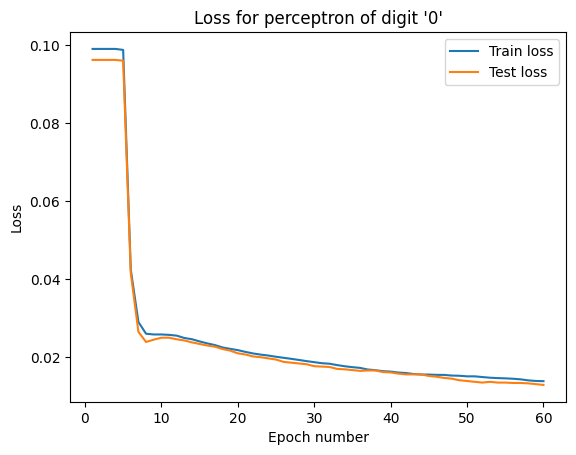

Digit = 1
accuracy on train data: 98.7%
True Negative (TN): 8841
False Positive (FP): 64
False Negative (FN): 52
True Positive (TP): 1043
True Positive Rate (TPR): 0.9525114155251142
True Negative Rate (TNR): 0.9928130263896687
Test data Accuracy (ACC): 0.9884



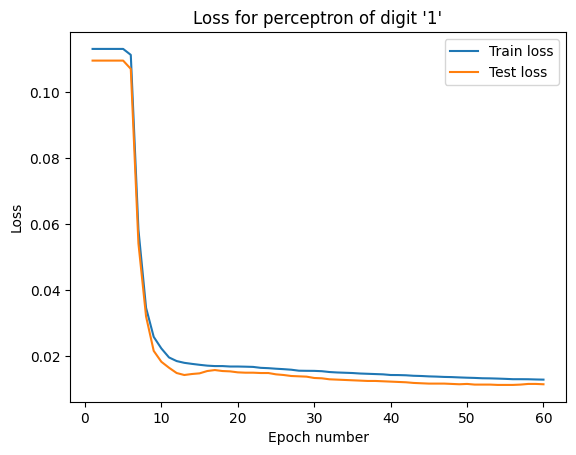

Digit = 2
accuracy on train data: 97.32833333333333%
True Negative (TN): 8857
False Positive (FP): 134
False Negative (FN): 147
True Positive (TP): 862
True Positive Rate (TPR): 0.8543111992071358
True Negative Rate (TNR): 0.9850962073184295
Test data Accuracy (ACC): 0.9719



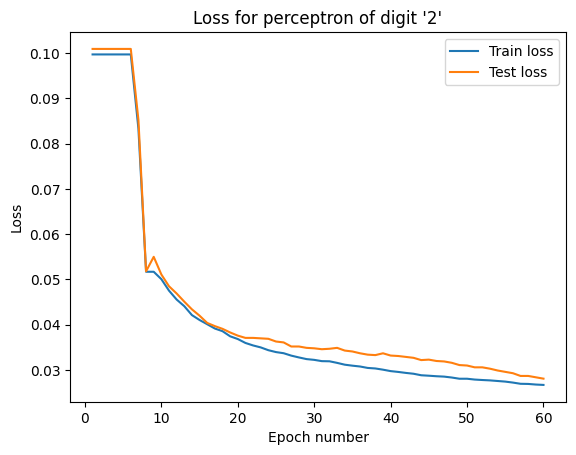

Digit = 3
accuracy on train data: 96.58%
True Negative (TN): 8786
False Positive (FP): 182
False Negative (FN): 147
True Positive (TP): 885
True Positive Rate (TPR): 0.8575581395348837
True Negative Rate (TNR): 0.9797056199821588
Test data Accuracy (ACC): 0.9671



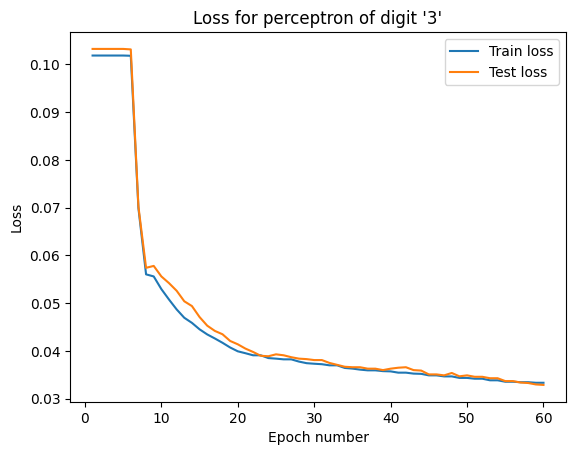

Digit = 4
accuracy on train data: 97.595%
True Negative (TN): 8858
False Positive (FP): 137
False Negative (FN): 120
True Positive (TP): 885
True Positive Rate (TPR): 0.8805970149253731
True Negative Rate (TNR): 0.9847693162868261
Test data Accuracy (ACC): 0.9743



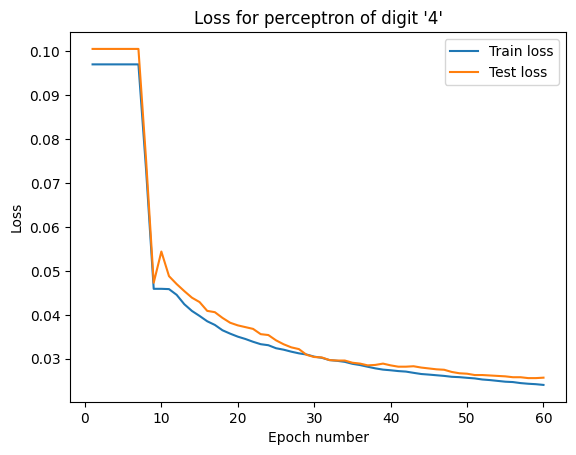

Digit = 5
accuracy on train data: 94.60166666666667%
True Negative (TN): 9087
False Positive (FP): 9
False Negative (FN): 549
True Positive (TP): 355
True Positive Rate (TPR): 0.3926991150442478
True Negative Rate (TNR): 0.9990105540897097
Test data Accuracy (ACC): 0.9442



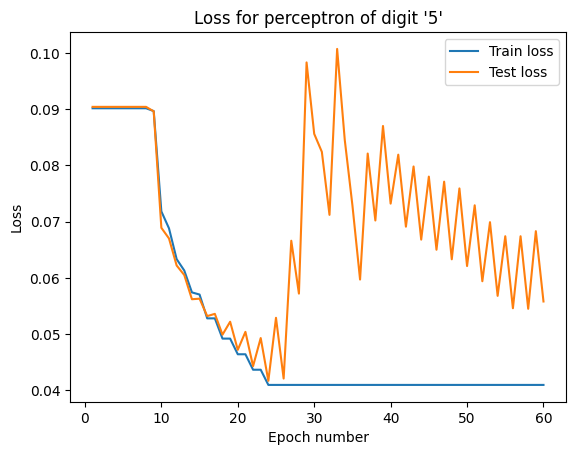

Digit = 6
accuracy on train data: 98.15833333333333%
True Negative (TN): 8893
False Positive (FP): 93
False Negative (FN): 83
True Positive (TP): 931
True Positive Rate (TPR): 0.9181459566074951
True Negative Rate (TNR): 0.9896505675495215
Test data Accuracy (ACC): 0.9824



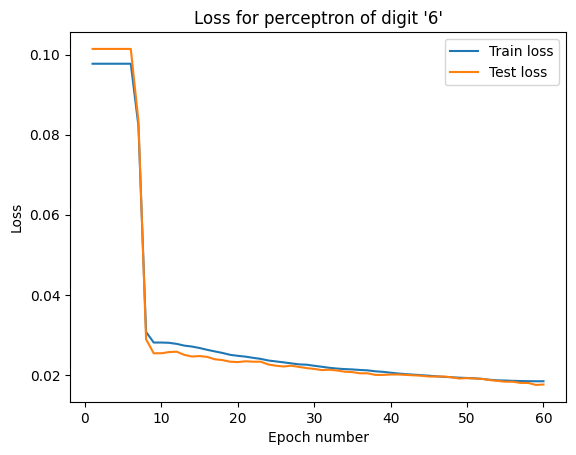

Digit = 7
accuracy on train data: 97.98333333333333%
True Negative (TN): 8841
False Positive (FP): 113
False Negative (FN): 82
True Positive (TP): 964
True Positive Rate (TPR): 0.9216061185468452
True Negative Rate (TNR): 0.9873799419253965
Test data Accuracy (ACC): 0.9805



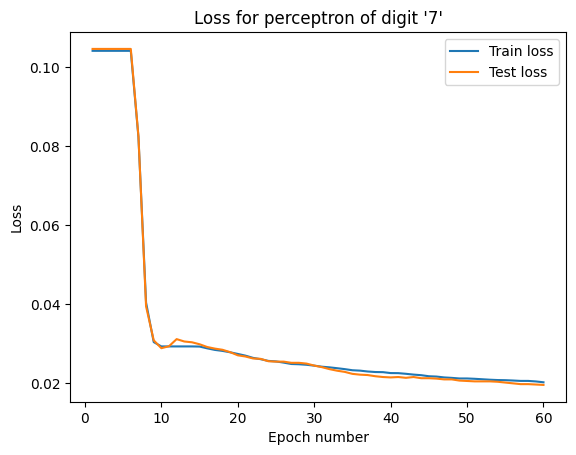

Digit = 8
accuracy on train data: 82.09833333333333%
True Negative (TN): 7349
False Positive (FP): 1675
False Negative (FN): 94
True Positive (TP): 882
True Positive Rate (TPR): 0.9036885245901639
True Negative Rate (TNR): 0.8143838652482269
Test data Accuracy (ACC): 0.8231



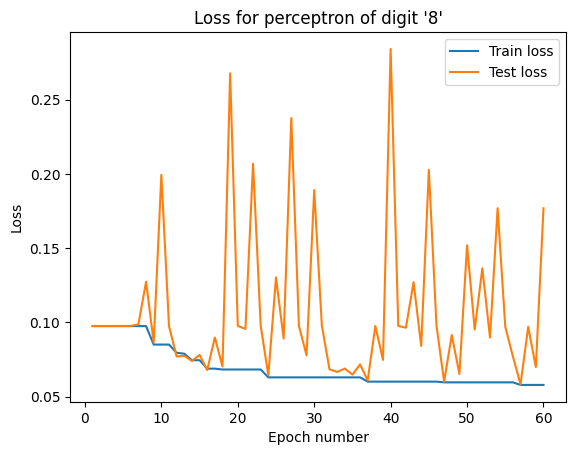

Digit = 9
accuracy on train data: 94.29166666666667%
True Negative (TN): 8993
False Positive (FP): 50
False Negative (FN): 523
True Positive (TP): 434
True Positive Rate (TPR): 0.4535005224660397
True Negative Rate (TNR): 0.9944708614397877
Test data Accuracy (ACC): 0.9427



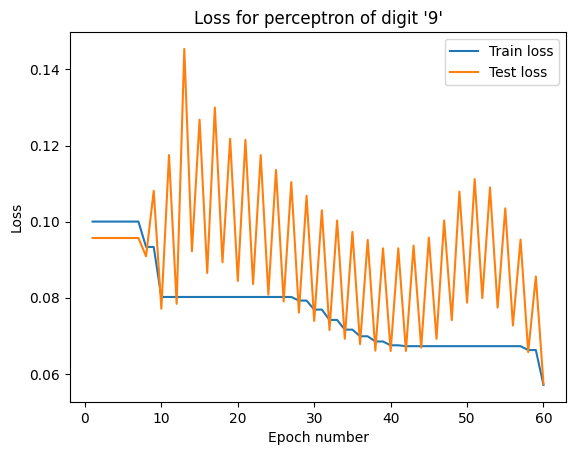

In [ ]:
# Train and show statistics on test data for every perceptron
weights = [] # Store weight vector of every perceptron
for digit in range(num_classes):
    print("Digit = " + str(digit))

    cur_perceptron = BinaryPerceptron(X_train, Y_train, X_test, Y_test,
                                      digit=digit)  # Instance the perceptron of digit = i

    weight = cur_perceptron.train_and_show_statistics(num_epochs)
    weights.append(weight)




## **Results**

As expected, the pocket algorithm ensures that the loss on the training data monotonically decreases, as evident from the plotted graphs.

In terms of accuracy, all perceptrons, except for the one dedicated to recognizing the digit '8', achieved a test data accuracy of at least 94%. For True Negative Rate (TNR), all perceptrons, except the one for '8', attained results of at least 98% on the test data.

Regarding True Positive Rate (TPR), some perceptrons achieved rates surpassing 90%, while others fell below 50%. This suggests that the algorithm excels in correctly identifying the wrong class but struggles to accurately identify images from the correct class.

The perceptron designed for the digit '8' demonstrated relatively high True Negatives (TN) but also exhibited a relatively high count of False Positives (FP). This issue mirrors the challenges faced by some other perceptrons, albeit to a greater extent.

Considering that from the perspective of a single perceptron, only 10% of the data belongs to the correct class, the weight of True Negatives (TN) on the accuracy measure is nine times more significant than True Positives (TP). Consequently, we achieve high accuracy for most digits.


## **Multi Digit Perceptron**

A Multi-digit perceptron is specifically designed for multi-classification problems where there are multiple classes for classification.

In this section, we'll utilize multiple weight vectors derived from the single-digit perceptrons in the preceding section to classify each image within the dataset.

We will develop, train, and test a multi-perceptron model, initializing the weight matrix with the 10 weight vectors obtained from the single-digit perceptron training.

For predictions, the label assigned will be the one corresponding to the highest score generated by the perceptron.

Moreover, we'll compute and display a confusion matrix and a Loss VS Epoch graph to evaluate and analyze the performance of this algorithm.

accuracy on train: 88.20333333333333%
accuracy on test: 88.0%
[[ 860    0    1    0    2    5    1    9    0    4]
 [   0 1013    4    1    1    3    4    2    3    2]
 [  10   15  871   23   15    8   28   33   16   10]
 [  12   22   20  898    5   65    3   11   33   26]
 [   2    1   26    0  881   15   15    9    1   27]
 [  48   10   13   56    5  751   38    5   34   11]
 [   6    0   18    3    8    4  905    0    1    0]
 [   0    0   11   13    1    2    2  925    7   28]
 [  24   33   40   35   28   44   18    5  867   20]
 [   0    1    5    3   59    7    0   47   14  829]]


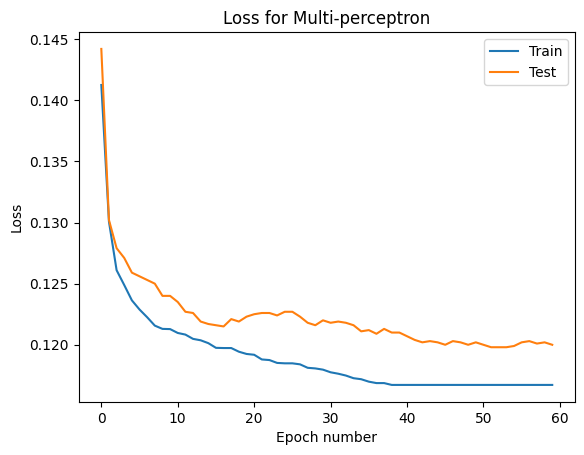

In [ ]:
# Train and show statistics on test data for the multi-class perceptron
W = np.vstack(weights)  # Make Weight matrix for the multi-digit perceptron
multi_perceptron = MultiPerceptron(W, X_train, Y_train, X_test, Y_test)  # Instance the multi-perceptron
multi_perceptron.train_and_show_statistics(num_epochs)

The examination of the confusion matrix offers nuanced insights into the MLP classifier's performance.

The diagonal elements showcase commendable accuracy in predicting specific digits, such as 1, 4, 5, and 7, which exhibit a higher number of correct classifications.

However, it's imperative to note the misclassifications, particularly between certain pairs of digits. For instance, the frequent confusion between digits 3 and 5 suggests a potential area of ambiguity in distinguishing these shapes. Similarly, the model encounters challenges differentiating between 4s and 9s, which could be attributed to their visual similarity in certain writing styles. These observed misclassifications indicate inherent complexities within the dataset that pose challenges for the classifier.

While the overall accuracy might be high, these specific areas of confusion highlight the necessity for a more nuanced evaluation using precision, recall, and F1-scores. Moreover, exploring misclassification patterns by visualizing the misclassified images or employing more advanced techniques, such as data augmentation or fine-tuning the model architecture, could aid in mitigating these challenges. Additionally, investigating misclassification reasons, such as noisy data or inherent similarities in digit representations, might unveil crucial avenues for model enhancement to achieve better differentiation among these intricate digit pairs.

  ## **Results**

The examination of the confusion matrix offers nuanced insights into the MLP classifier's performance.

The diagonal elements showcase commendable accuracy in predicting specific digits, such as 1, 4, 5, and 7, which exhibit a higher number of correct classifications.

However, it's imperative to note the misclassifications, particularly between certain pairs of digits. For instance, the frequent confusion between digits 3 and 5 suggests a potential area of ambiguity in distinguishing these shapes. Similarly, the model encounters challenges differentiating between 4s and 9s, which could be attributed to their visual similarity in certain writing styles. These observed misclassifications indicate inherent complexities within the dataset that pose challenges for the classifier.

While the overall accuracy might be high (88%), these specific areas of confusion highlight the necessity for a more nuanced evaluation using precision, recall, and F1-scores.
Moreover, exploring misclassification patterns by visualizing the misclassified images or employing more advanced techniques, such as data augmentation could aid in mitigating these challenges.

Additionally, investigating misclassification reasons, such as noisy data or inherent similarities in digit representations, might unveil crucial avenues for model enhancement to achieve better differentiation among these intricate digit pairs.